# 1-2,图片数据建模流程范例

In [2]:
import os
import datetime

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 

### 一，准备数据

cifar2数据集为cifar10数据集的子集，只包括前两种类别airplane和automobile。

训练集有airplane和automobile图片各5000张，测试集有airplane和automobile图片各1000张。

cifar2任务的目标是训练一个模型来对飞机airplane和机动车automobile两种图片进行分类。

我们准备的Cifar2数据集的文件结构如下所示。

![](./data/cifar2.jpg)

在Pytorch中构建图片数据管道通常有两种方法。

第一种是使用 torchvision中的datasets.ImageFolder来读取图片然后用 DataLoader来并行加载。

第二种是通过继承 torch.utils.data.Dataset 实现用户自定义读取逻辑然后用 DataLoader来并行加载。

第二种方法是读取用户自定义数据集的通用方法，既可以读取图片数据集，也可以读取文本数据集。

本篇我们介绍第一种方法。


In [4]:
import torch 
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,datasets 

In [5]:
transform_train = transforms.Compose(
    [transforms.ToTensor()])
transform_valid = transforms.Compose(
    [transforms.ToTensor()])

In [6]:
ds_train = datasets.ImageFolder("./data/cifar2/train/",
            transform = transform_train,target_transform= lambda t:torch.tensor([t]).float())
ds_valid = datasets.ImageFolder("./data/cifar2/test/",
            transform = transform_train,target_transform= lambda t:torch.tensor([t]).float())

print(ds_train.class_to_idx)

{'0_airplane': 0, '1_automobile': 1}


```
{'0_airplane': 0, '1_automobile': 1}
```

In [7]:
dl_train = DataLoader(ds_train,batch_size = 50,shuffle = True,num_workers=3)
dl_valid = DataLoader(ds_valid,batch_size = 50,shuffle = True,num_workers=3)

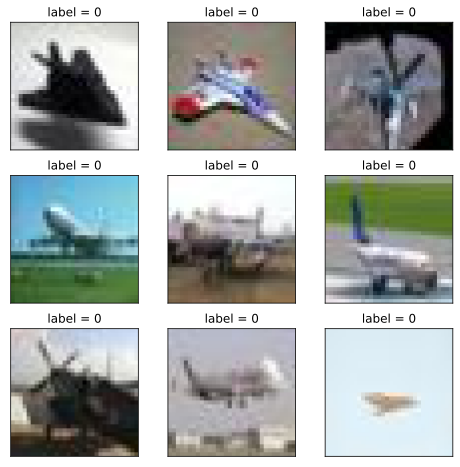

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label.item())
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()


![](./data/1-2-查看样本.png)

In [14]:
# Pytorch的图片默认顺序是 Batch,Channel,Width,Height
for x,y in dl_train:
    print(x.shape,y.shape) 
    break
    

torch.Size([50, 3, 32, 32]) torch.Size([50, 1])


```
torch.Size([50, 3, 32, 32]) torch.Size([50, 1])
```

### 二，定义模型

使用Pytorch通常有三种方式构建模型：使用nn.Sequential按层顺序构建模型，继承nn.Module基类构建自定义模型，继承nn.Module基类构建模型并辅助应用模型容器(nn.Sequential,nn.ModuleList,nn.ModuleDict)进行封装。

此处选择通过继承nn.Module基类构建自定义模型。

In [15]:
#测试AdaptiveMaxPool2d的效果
pool = nn.AdaptiveMaxPool2d((1,1))
t = torch.randn(10,8,32,32)
pool(t).shape 

torch.Size([10, 8, 1, 1])

```
torch.Size([10, 8, 1, 1])
```

In [16]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size = 3)
        self.pool = nn.MaxPool2d(kernel_size = 2,stride = 2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5)
        self.dropout = nn.Dropout2d(p = 0.1)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64,32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        y = self.sigmoid(x)
        return y
        
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


```
Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten()
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
```

In [17]:
import torchkeras
torchkeras.summary(net,input_shape= (3,32,32))

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/metrics/__init__.py:44: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  "`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package"


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
          Sigmoid-11                    [-1, 1]               0
Total params: 54,273
Trainable params: 54,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.011719
Forwar

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
          Sigmoid-11                    [-1, 1]               0
================================================================
Total params: 54,273
Trainable params: 54,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.011719
Forward/backward pass size (MB): 0.359634
Params size (MB): 0.207035
Estimated Total Size (MB): 0.578388
----------------------------------------------------------------
```

### 三，训练模型

Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。

有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。

此处介绍一种较通用的函数形式训练循环。


In [18]:
import pandas as pd 
from sklearn.metrics import roc_auc_score

model = net
model.optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)
model.loss_func = torch.nn.BCELoss()
model.metric_func = lambda y_pred,y_true: roc_auc_score(y_true.data.numpy(),y_pred.data.numpy())
model.metric_name = "auc"


In [19]:
def train_step(model,features,labels):
    
    # 训练模式，dropout层发生作用
    model.train()
    
    # 梯度清零
    model.optimizer.zero_grad()
    
    # 正向传播求损失
    predictions = model(features)
    loss = model.loss_func(predictions,labels)
    metric = model.metric_func(predictions,labels)

    # 反向传播求梯度
    loss.backward()
    model.optimizer.step()

    return loss.item(),metric.item()

def valid_step(model,features,labels):
    
    # 预测模式，dropout层不发生作用
    model.eval()
    # 关闭梯度计算
    with torch.no_grad():
        predictions = model(features)
        loss = model.loss_func(predictions,labels)
        metric = model.metric_func(predictions,labels)
    
    return loss.item(), metric.item()


# 测试train_step效果
features,labels = next(iter(dl_train))
train_step(model,features,labels)


(0.6895754337310791, 0.31980519480519476)

```
(0.6922046542167664, 0.5088566827697262)
```

In [20]:
def train_model(model,epochs,dl_train,dl_valid,log_step_freq):

    metric_name = model.metric_name
    dfhistory = pd.DataFrame(columns = ["epoch","loss",metric_name,"val_loss","val_"+metric_name]) 
    print("Start Training...")
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("=========="*8 + "%s"%nowtime)

    for epoch in range(1,epochs+1):  

        # 1，训练循环-------------------------------------------------
        loss_sum = 0.0
        metric_sum = 0.0
        step = 1

        for step, (features,labels) in enumerate(dl_train, 1):

            loss,metric = train_step(model,features,labels)

            # 打印batch级别日志
            loss_sum += loss
            metric_sum += metric
            if step%log_step_freq == 0:   
                print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                      (step, loss_sum/step, metric_sum/step))

        # 2，验证循环-------------------------------------------------
        val_loss_sum = 0.0
        val_metric_sum = 0.0
        val_step = 1

        for val_step, (features,labels) in enumerate(dl_valid, 1):

            val_loss,val_metric = valid_step(model,features,labels)

            val_loss_sum += val_loss
            val_metric_sum += val_metric

        # 3，记录日志-------------------------------------------------
        info = (epoch, loss_sum/step, metric_sum/step, 
                val_loss_sum/val_step, val_metric_sum/val_step)
        dfhistory.loc[epoch-1] = info

        # 打印epoch级别日志
        print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
              "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") 
              %info)
        nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print("\n"+"=========="*8 + "%s"%nowtime)

    print('Finished Training...')
    
    return dfhistory

In [21]:
epochs = 20

dfhistory = train_model(model,epochs,dl_train,dl_valid,log_step_freq = 50)


Start Training...
================================================================================2021-06-30 15:29:27
[step = 50] loss: 0.694, auc: 0.514
[step = 100] loss: 0.693, auc: 0.576
[step = 150] loss: 0.691, auc: 0.615
[step = 200] loss: 0.690, auc: 0.640

EPOCH = 1, loss = 0.690,auc  = 0.640, val_loss = 0.684, val_auc = 0.791

================================================================================2021-06-30 15:29:48
[step = 50] loss: 0.683, auc: 0.754
[step = 100] loss: 0.682, auc: 0.749
[step = 150] loss: 0.681, auc: 0.751
[step = 200] loss: 0.679, auc: 0.753

EPOCH = 2, loss = 0.679,auc  = 0.753, val_loss = 0.669, val_auc = 0.811

================================================================================2021-06-30 15:29:54
[step = 50] loss: 0.669, auc: 0.775
[step = 100] loss: 0.666, auc: 0.780
[step = 150] loss: 0.663, auc: 0.778
[step = 200] loss: 0.660, auc: 0.777

EPOCH = 3, loss = 0.660,auc  = 0.777, val_loss = 0.639, val_auc = 0.815

===================

```
Start Training...
================================================================================2020-06-28 20:47:56
[step = 50] loss: 0.691, auc: 0.627
[step = 100] loss: 0.690, auc: 0.673
[step = 150] loss: 0.688, auc: 0.699
[step = 200] loss: 0.686, auc: 0.716

EPOCH = 1, loss = 0.686,auc  = 0.716, val_loss = 0.678, val_auc = 0.806

================================================================================2020-06-28 20:48:18
[step = 50] loss: 0.677, auc: 0.780
[step = 100] loss: 0.675, auc: 0.775
[step = 150] loss: 0.672, auc: 0.782
[step = 200] loss: 0.669, auc: 0.779

EPOCH = 2, loss = 0.669,auc  = 0.779, val_loss = 0.651, val_auc = 0.815

......

================================================================================2020-06-28 20:54:24
[step = 50] loss: 0.386, auc: 0.914
[step = 100] loss: 0.392, auc: 0.913
[step = 150] loss: 0.395, auc: 0.911
[step = 200] loss: 0.398, auc: 0.911

EPOCH = 19, loss = 0.398,auc  = 0.911, val_loss = 0.449, val_auc = 0.924

================================================================================2020-06-28 20:54:43
[step = 50] loss: 0.416, auc: 0.917
[step = 100] loss: 0.417, auc: 0.916
[step = 150] loss: 0.404, auc: 0.918
[step = 200] loss: 0.402, auc: 0.918

EPOCH = 20, loss = 0.402,auc  = 0.918, val_loss = 0.535, val_auc = 0.925

================================================================================2020-06-28 20:55:03
Finished Training...
```

### 四，评估模型

In [22]:
dfhistory 

,epoch,loss,auc,val_loss,val_auc
0,1.0,0.689794,0.640465,0.683753,0.791354
1,2.0,0.679040,0.753068,0.668612,0.810655
2,3.0,0.659660,0.776875,0.638643,0.815245
3,4.0,0.621918,0.779765,0.584952,0.811297
4,5.0,0.576301,0.784472,0.542594,0.815371
5,6.0,0.550678,0.793659,0.517629,0.830770
6,7.0,0.534296,0.810363,0.499027,0.838475
7,8.0,0.518622,0.820194,0.484623,0.852062
8,9.0,0.510373,0.829754,0.475042,0.854943
9,10.0,0.497704,0.839894,0.462172,0.868338


![](./data/1-2-dfhistory.png)

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

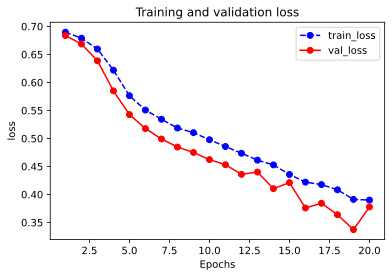

In [27]:
plot_metric(dfhistory,"loss")

![](./data/1-2-loss曲线.png)

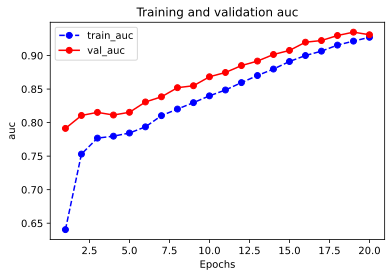

In [28]:
plot_metric(dfhistory,"auc")

![](./data/1-2-auc曲线.png)

### 五，使用模型

In [29]:
def predict(model,dl):
    model.eval()
    with torch.no_grad():
        result = torch.cat([model.forward(t[0]) for t in dl])
    return(result.data)

In [32]:
#预测概率
y_pred_probs = predict(model,dl_valid)
y_pred_probs

tensor([[0.0034],
        [0.7355],
        [0.0132],
        ...,
        [0.1098],
        [0.7703],
        [0.2101]])

```
tensor([[8.4032e-01],
        [1.0407e-02],
        [5.4146e-04],
        ...,
        [1.4471e-02],
        [1.7673e-02],
        [4.5081e-01]])
```

In [33]:
#预测类别
y_pred = torch.where(y_pred_probs>0.5,
        torch.ones_like(y_pred_probs),torch.zeros_like(y_pred_probs))
y_pred

tensor([[0.],
        [1.],
        [0.],
        ...,
        [0.],
        [1.],
        [0.]])

```
tensor([[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])
```

### 六，保存模型

推荐使用保存参数方式保存Pytorch模型。

In [34]:
print(model.state_dict().keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias'])


```
odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias'])
```

In [35]:
# 保存模型参数

torch.save(model.state_dict(), "./data/model_parameter.pkl")

net_clone = Net()
net_clone.load_state_dict(torch.load("./data/model_parameter.pkl"))

predict(net_clone,dl_valid)

tensor([[0.0250],
        [0.0715],
        [0.4210],
        ...,
        [0.1307],
        [0.0167],
        [0.2152]])

```
tensor([[0.0204],
        [0.7692],
        [0.4967],
        ...,
        [0.6078],
        [0.7182],
        [0.8251]])
```

**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](./data/算法美食屋二维码.jpg)